In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import nengo

This notebook gives a brief introduction to one particular method for evaluating what a network of neurons can do.

The overall goal is to be able to adjust a neuron model and find out how those adjustments will affect what a connected network of neurons is capable of.  The particular approach taken here is the basis of the Neural Engineering Framework, so it's the one I'm most familiar with, but I definitely don't want to claim this is the only approach.  But I do think it's a good place to start.  After all, it is extremely similar to the approaches used in the early Perceptron days of neural networks.

We'll begin by just looking at a single neuron.  All we need is some simple code to create a neuron, feed it some input, and get some output.  Here is an incredibly simple integrate-and-fire model:

In [2]:
class SimpleNeuron:
    def __init__(self):
        self.v = 0
    def step(self, J):
        self.v += J
        if self.v < 0:
            self.v = 0
        if self.v > 5:
            spike = 1
            self.v = 0
        else:
            spike = 0
        return spike

We'll use that model as an example here, but in a more complex case that code could be anything we want, including some highly detailed SPICE model.

Now, let's generate some input and see what it does.  I'll use the Nengo `WhiteSignal` class to generate a band-limited white noise (upper bound of 5Hz, sampled at a dt of 1ms).  Then I'll feed that into the neuron and see what the output looks like.

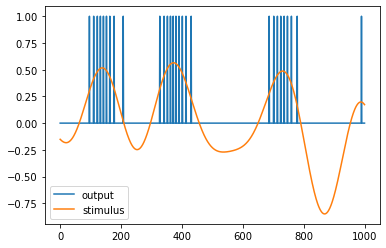

In [3]:
stim = nengo.processes.WhiteSignal(period=10, high=5, seed=1).run(1, dt=0.001)

n = SimpleNeuron()

output = np.zeros_like(stim)
for i, J in enumerate(stim):
    output[i] = n.step(J)

plt.plot(output, label='output')
plt.plot(stim, label='stimulus')
plt.legend()



Great!  We have a system that does some sort of nonlinearity.  Importantly, this can be anything at all.  It doesn't even need to be spiking -- we could also have defined the output to be a real continuous value.  It's all up to whatever neuron model you are interested in.

But, our goal is to look at what lots of neurons together can do.  So, we need to make a bunch of these and connect them somehow.

We'll go with the simplest possible way to connect them: Just a feed-forward system with a bunch of neurons in the hidden layer, with something to take our input and present it to the neurons.  Importantly, we don't want each neuron to do exactly the same thing -- if we did that each neuron would behave identically.  So we need some sort of differences among the neurons.

There are two sources of differences: things internal to the neuron, and things external to the neuron.  Internal features might be the precise threshold or gain of the neuron (or the various complications due to transistor mismatch).  External features might be something about how the input is transformed before reaching the neuron.

For this simple example, let's define a weight matrix E (for *encoder*) that we will multiply the inputs by, and then add a bias term B for each neuron.  We'll generate these randomly.  Of course, the exact distribution that we're sampling from will affect the overall performance.  In the NEF/Nengo, there are tools for generating good distributions for some neuron models, but let's ignore that here and just generate them randomly.

These E and B values might be internal to the neuron or external to the neuron.  Since this is such a simple neuron model, let's treat them as external to the neuron and just have them affect the input value.

In [4]:
N = 50  # how many neurons there are
neurons = [SimpleNeuron() for i in range(N)]
E = np.random.normal(size=(50, 1))
B = np.random.normal(size=(N))*0.1

Now let's feed that same stimulus to all the neurons and see how they behave.

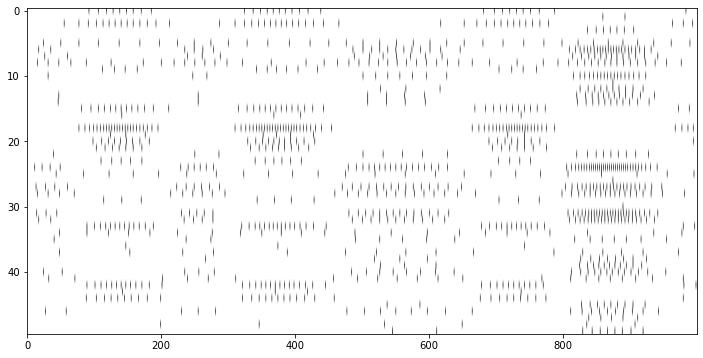

In [5]:
A = np.zeros((len(stim), N))
for i, J in enumerate(stim):
    Js = np.dot(E, J)
    for k, JJ in enumerate(Js):
        A[i,k] = neurons[k].step(JJ+B[k])
        
plt.figure(figsize=(12,6))
plt.imshow(A.T, aspect='auto', cmap='gray_r')
plt.show()

Now we have some nice diverse neural activity.  So, the question is, what can we do with this?

If we're doing some sort of computation with the neurons, then we should be able to express it by saying that given some input, we have some desired output.  This can be anything that we want, so let's start with the simplest thing possible: Can we compute the function $y(t) = x(t)$ (i.e. the identity function).

Given the system described above, we can find a set of weights D that we can multiply the output of the neurons by to give our target.  This can be solved in lots of different ways, and nengo has a bunch of these solvers built in (including L1 and non-negative solvers), but let's stick with the default least-squares L2 solver.  All we have to do is give it A (the output of our neurons) and the target that we want.  It will return D (the weight matrix) and `info`, which contains various information about the solver process, including the RMSE error from the solving.

- Note: this RMSE is the *training* error, not the testing error.  To get the testing error, either generate a separate input stimulus and the activity, or only give part of the A and target matrices to the solver
- Note: the least-squares method has a default regularization term of 0.1.  This is very high, and is meant to be a good default when using spiking neurons.  If you have non-spiking neurons, you might improve performance by reducing this, although then runs the risk of over-fitting.  Which is another good reason to separately compute the testing error.

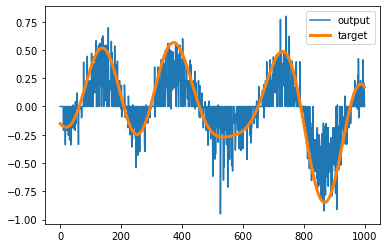

RMSE: [0.22111017]


In [6]:
target = stim

D, info = nengo.solvers.LstsqL2()(A, target)


plt.plot(A.dot(D), label='output')
plt.plot(target, lw=3, label='target')
plt.legend()
plt.show()
print('RMSE:', info['rmses'])

That's not great, but it's doing what we want, and if we increase the number of neurons, then we could do better.  However, there's also something else we could do to increase the accuracy.  With spiking neuron models, it's very common to have a low-pass filter (i.e. a synapse) after the spike.  Let's see what our output looks like with a low-pass filter applied.

Nengo also has this built-in with the `nengo.synapses.Lowpass` object.

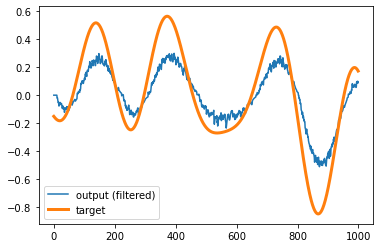

In [7]:
filt = nengo.synapses.Lowpass(0.01)
plt.plot(filt.filt(A.dot(D)), label='output (filtered)')
plt.plot(target, lw=3, label='target')
plt.legend()
plt.show()

That's better, but still not great.   But that's because the solver didn't know about this low-pass filter!  So let's low-pass filter the activity before giving it to the solver and get a new set of decoders that should work in this situation.

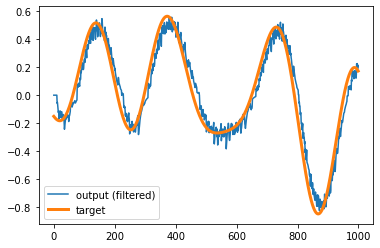

RMSE: [0.08886721]


In [8]:
filt = nengo.synapses.Lowpass(0.01)
D, info = nengo.solvers.LstsqL2()(filt.filt(A), target)
plt.plot(filt.filt(A.dot(D)), label='output (filtered)')
plt.plot(target, lw=3, label='target')
plt.legend()
plt.show()
print('RMSE:', info['rmses'])

Nice!  Now that we have this working, we can of course also try to have the system compute functions of the input.  For example, here's $y(t)=x(t)^2$.

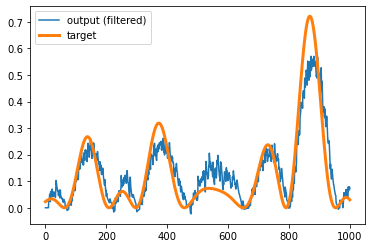

RMSE: [0.06603211]


In [9]:
target = stim**2
filt = nengo.synapses.Lowpass(0.01)
D, info = nengo.solvers.LstsqL2()(filt.filt(A), target)
plt.plot(filt.filt(A.dot(D)), label='output (filtered)')
plt.plot(target, lw=3, label='target')
plt.legend()
plt.show()
print('RMSE:', info['rmses'])

And here's $y(t)=sin(8 x(t))$

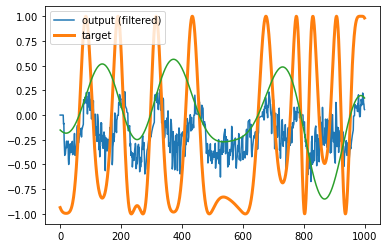

RMSE: [0.62327732]


In [10]:
target = np.sin(stim*8)
filt = nengo.synapses.Lowpass(0.01)
D, info = nengo.solvers.LstsqL2()(filt.filt(A), target)
plt.plot(filt.filt(A.dot(D)), label='output (filtered)')
plt.plot(target, lw=3, label='target')
plt.plot(stim)
plt.legend()
plt.show()
print('RMSE:', info['rmses'])

It didn't do that very well at all, which is pretty expected.  With more neurons it should do better, but that's a pretty hard function to approximate.

You can also use this method to try to decode functions of time.  For example, we could have the target be whatever the input was 15ms ago. 

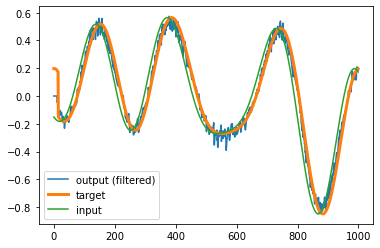

RMSE: [0.05144632]


In [11]:
target = np.roll(stim, 15)
filt = nengo.synapses.Lowpass(0.01)
D, info = nengo.solvers.LstsqL2()(filt.filt(A), target)
plt.plot(filt.filt(A.dot(D)), label='output (filtered)')
plt.plot(target, lw=3, label='target')
plt.plot(stim, label='input')
plt.legend()
plt.show()
print('RMSE:', info['rmses'])

It's even better at that than it is at computing $y(t)=x(t)$.  This is partly due to the intrinsic temporal response of the neurons (a spike is an indication the input value in the near past) and partly to do with the low-pass filter that's being applied.

Of course, for more complex functions and longer windows of time, the network will do poorly.

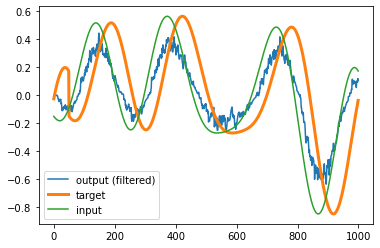

RMSE: [0.2554941]


In [12]:
target = np.roll(stim, 50)
filt = nengo.synapses.Lowpass(0.01)
D, info = nengo.solvers.LstsqL2()(filt.filt(A), target)
plt.plot(filt.filt(A.dot(D)), label='output (filtered)')
plt.plot(target, lw=3, label='target')
plt.plot(stim, label='input')
plt.legend()
plt.show()
print('RMSE:', info['rmses'])

This approach does also generalize to more dimensions on the input and output.  Here we have a 2D input and a 3D output.

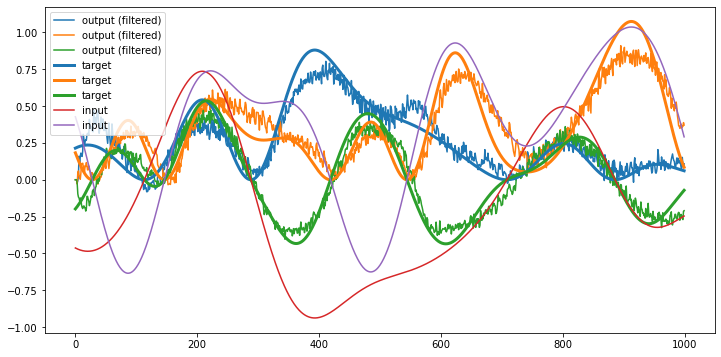

RMSE: [0.08924256 0.11385716 0.07212292]


In [13]:
stim = nengo.processes.WhiteSignal(period=10, high=5, seed=1).run(1, dt=0.001, d=2)

N = 500  # how many neurons there are
neurons = [SimpleNeuron() for i in range(N)]
E = np.random.normal(size=(50, 2))
B = np.random.normal(size=(N))*0.1

A = np.zeros((len(stim), N))
for i, J in enumerate(stim):
    Js = np.dot(E, J)
    for k, JJ in enumerate(Js):
        A[i,k] = neurons[k].step(JJ+B[k])
        
target = [(x[0]**2, x[1]**2, x[0]*x[1]) for x in stim]
filt = nengo.synapses.Lowpass(0.01)
D, info = nengo.solvers.LstsqL2()(filt.filt(A), target)
plt.figure(figsize=(12,6))
plt.plot(filt.filt(A.dot(D)), label='output (filtered)')
plt.gca().set_prop_cycle(None)
plt.plot(target, lw=3, label='target')
plt.plot(stim, label='input')
plt.legend()
plt.show()
print('RMSE:', info['rmses'])

## Next steps

Given this approach, there are a few different directions you can go.  Here are some ideas:

### Examine different classes of functions

Normally with LIF neurons (and other simple neuron models), we have done things like looking at computing polynomial functions (i.e. $x$, $x^2$, $x^3$, and so on).  In the Braindrop paper http://compneuro.uwaterloo.ca/publications/neckar2019.html we did $y(t)=sin(f \pi x(t))$ for f=1, 2, 4.... 

### Examine the effects of interaction between the neurons

The neurons can be made to interact with each other, and the entire process described here would still work.  All that would do would be to turn the neurons into a reservoir system, and the decoder D is the standard readout weights from the reservoir.  You can either do this with standard connection weights (either randomly chosen or even optimally chosen via the LMU approach, as you can use the same decoder trick discussed here to find the weights that will implement the LMU differential equation), or you could also include this as part of the SPICE model, if you have some other way of having the neurons interact with each other.  This should allow for much more complex temporal functions.

### Examine different encoder implementations

You can also change the input system from a simple linear matrix E to anything else you want.  In Braindrop, we used a configurable diffusor mesh to do something like the E matrix.  The transistor mismatch and gradual spread meant different neurons got different strengths of input, although it did require us to change the input into positive and negative spikes being injected into different points of the mesh.  Again, this doesn't change any of the decoder computation process, so all of the processes described here should still work.